In [13]:
# main issues:
# fix stop loss/ max wdd
# partial fills
# multiple pairs at one time
# issues with multiple pairs with similar legs, memory management
# trailing profit take
#     1) take 
#     1) sell bad leg and use winning leg to run    

# innovations
# increase volume
# make new models whcih are scalping or momentum models

# kalmans filters
# copulas
# nonlinear distributions
# extreme value theory
# last three are similar
# pair trading with multiple exchanges

# limit orders
# max win drawdown
# advanced risk mitigation 
# if long and first priotirty to get rid off -> sell at market
# if short and first prioity to get rid off -> sell at market
# pair splitting

# ---

# need to fix
# order sizes mgiht be too small so need to take into consideration leg prices and sizes

In [14]:
# imports and requirements
import json
import requests
import pandas as pd
import numpy as np
import ccxt
import time
import datetime as dt
import matplotlib.pyplot as plt

from binance.client import Client
from binance.enums import *

In [15]:
# init client
apiKey = 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh'
apiSecret = 'bsY8Jh1A4jFNv8xLNWbRBff8MPoKQKeyB601YFoSRMiozHRZ4hj3m7pJFcMBIjy5'

# python-binance init
client = Client(apiKey, apiSecret)
# ccxt init
exchange = ccxt.binance({
    'apiKey': 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh',
    'secret': 'bsY8Jh1A4jFNv8xLNWbRBff8MPoKQKeyB601YFoSRMiozHRZ4hj3m7pJFcMBIjy5',
    'enableRateLimit': True,  # as required by the Manual
    'options': { 'defaultType': 'future' }
})

In [16]:
# inputs
# leg1 = input("Input leg 1: ")
# leg2 = input("Input leg 2: ")
# timeframe = input("Input timeframe/ interval: ")
# emalen = input("Input Lookback/ EMA length: ")
# legval = float(input("Leg Value: "))

leg1 = 'ETHUSDT'
leg2 = 'XTZUSDT'
timeframe = '30m'
emalen = '40'
legval = float(input("Leg Value: "))

# convert legs
if leg1 == 'ONTUSDT':
    newLeg1 = 'ONT/USDT'
    # prec = 1 dp, 4 price
elif leg1 == 'ETHUSDT':
    newLeg1 = 'ETH/USDT'
    # prec = 3 dp, 2 price
elif leg1 == 'BCHUSDT':
    newLeg1 = 'BCH/USDT'
    # prec = 3 dp, 2 price
elif leg1 == 'TRXUSDT':
    newleg1 = 'TRX/USDT'
    # prec = 0 dp, 5 price
    
if leg2 == 'QTUMUSDT':
    newLeg2 = 'QTUM/USDT'
    # prec = 1 dp, 3 price
elif leg2 == 'XTZUSDT':
    newLeg2 = 'XTZ/USDT'
    # prec = 1 dp, 3 price
elif leg2 == 'LTCUSDT':
    newLeg2 = 'LTC/USDT'
    # prec = 3 dp, 2 price
elif leg2 == 'BATUSDT':
    newLeg2 = 'BAT/USDT'
    # prec = 1 dp, 4 price

print("New leg 1:", format(newLeg1))
print("New leg 2:", format(newLeg2))


Leg Value: 5
New leg 1: ETH/USDT
New leg 2: XTZ/USDT


In [17]:
# create dataframe
def dataframe(symbol, interval, timeframe):
    rootUrl = 'https://api.binance.com/api/v1/klines'
    url = rootUrl + '?symbol=' + symbol + '&interval=' + interval + '&limit=' + timeframe
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                 'o', 'h', 'l', 'c', 'v',
                 'closeTime', 'qav', 'numTrades',
                 'takerBase_Bol', 'takerQuoteVol', 'ignore']
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.closeTime]
    return df

dataframe(leg1, timeframe, emalen)

,open_time,o,h,l,c,v,closeTime,qav,numTrades,takerBase_Bol,takerQuoteVol,ignore
2020-06-06 23:29:59.999,1591448400000,241.84000000,242.71000000,241.82000000,242.46000000,7699.85105000,1591450199999,1865221.79746010,3156,3666.53060000,888088.51295760,0
2020-06-06 23:59:59.999,1591450200000,242.44000000,242.79000000,241.36000000,242.03000000,6642.43789000,1591451999999,1607962.62392520,2772,3686.79748000,892601.39746410,0
2020-06-07 00:29:59.999,1591452000000,242.04000000,242.34000000,241.50000000,241.68000000,9433.08583000,1591453799999,2282286.82898460,3474,5383.56982000,1302869.71476850,0
2020-06-07 00:59:59.999,1591453800000,241.65000000,242.30000000,241.63000000,242.16000000,6282.03131000,1591455599999,1520048.49226720,2462,2073.27183000,501600.88284770,0
2020-06-07 01:29:59.999,1591455600000,242.15000000,242.30000000,241.50000000,241.84000000,4299.66240000,1591457399999,1040329.52926100,2325,1855.07974000,448798.57231670,0
2020-06-07 01:59:59.999,1591457400000,241.86000000,242.76000000,241.67000000,242.32000000,5572.60565000,1591459199999,1350516.17548900,2568,2456.26995000,595362.63053120,0
2020-06-07 02:29:59.999,1591459200000,242.31000000,243.41000000,242.02000000,242.55000000,10734.33684000,1591460999999,2607188.63399360,3551,5695.21235000,1383181.01596820,0
2020-06-07 02:59:59.999,1591461000000,242.50000000,242.76000000,239.77000000,240.97000000,24768.99046000,1591462799999,5967606.61234910,7522,11529.90925000,2779882.36237780,0
2020-06-07 03:29:59.999,1591462800000,240.96000000,240.96000000,239.90000000,240.45000000,14529.19327000,1591464599999,3491281.85815610,4220,6440.85470000,1547749.73254600,0
2020-06-07 03:59:59.999,1591464600000,240.43000000,240.95000000,239.80000000,240.76000000,7572.60488000,1591466399999,1819862.73554220,2941,3130.98183000,752674.71715260,0


In [18]:
# hedge price function
def priceChart():
    leg1Chart= dataframe(leg1,timeframe, emalen)
    leg2Chart = dataframe(leg2,timeframe, emalen)

    leg1ChartClose = leg1Chart['c'].astype('float')
    leg2ChartClose = leg2Chart['c'].astype('float')

    hedgeChart = leg1ChartClose / leg2ChartClose
    return hedgeChart
priceChart()

2020-06-06 23:29:59.999    82.265124
2020-06-06 23:59:59.999    82.272758
2020-06-07 00:29:59.999    82.164955
2020-06-07 00:59:59.999    82.316949
2020-06-07 01:29:59.999    81.863110
2020-06-07 01:59:59.999    82.181374
2020-06-07 02:29:59.999    82.245431
2020-06-07 02:59:59.999    82.447737
2020-06-07 03:29:59.999    82.331793
2020-06-07 03:59:59.999    82.567989
2020-06-07 04:29:59.999    82.560494
2020-06-07 04:59:59.999    82.715880
2020-06-07 05:29:59.999    82.690789
2020-06-07 05:59:59.999    82.831646
2020-06-07 06:29:59.999    82.852740
2020-06-07 06:59:59.999    82.964003
2020-06-07 07:29:59.999    82.778537
2020-06-07 07:59:59.999    82.845831
2020-06-07 08:29:59.999    82.907124
2020-06-07 08:59:59.999    82.923314
2020-06-07 09:29:59.999    82.795809
2020-06-07 09:59:59.999    82.739988
2020-06-07 10:29:59.999    82.715753
2020-06-07 10:59:59.999    82.742002
2020-06-07 11:29:59.999    82.928586
2020-06-07 11:59:59.999    82.934183
2020-06-07 12:29:59.999    83.370932
2

In [19]:
priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
amountLeg1 = round(legval/priceLeg1,3)
print ("Amount of leg1: {}". format(amountLeg1))

Amount of leg1: 0.021


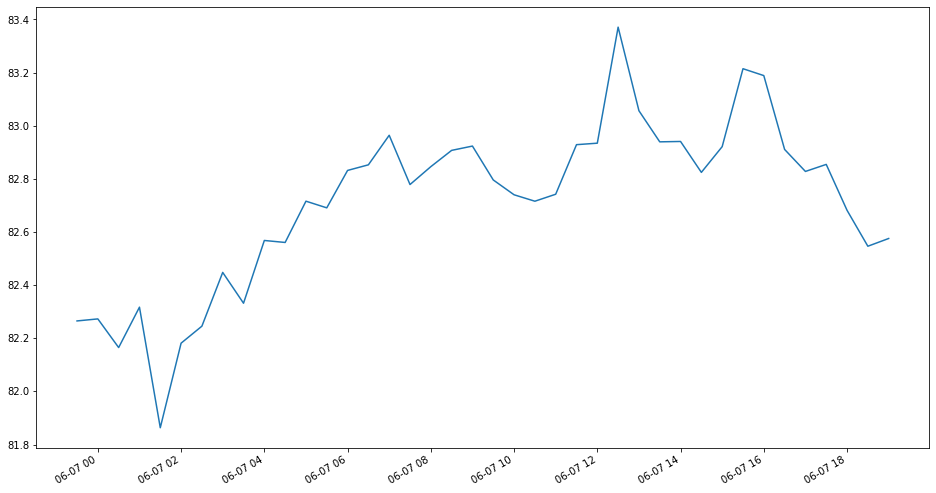

In [20]:
# prints price chart
priceChart().plot(figsize=(16,9))

In [21]:
# current zscore
def currZscore():
    currStd = priceChart().std()
    currMean = priceChart().mean()
    a = priceChart().tolist()
    x = a[-1:]
    
    y = [float(i) for i in x]

    zscore = (y[0] - currMean)/currStd
    return round(zscore,5)

print("Current Z-Score = %s" % currZscore())

Current Z-Score = -0.43632


In [22]:
# short buy and long exit
def shortSide(leg1, leg2, legval):
    
    print("Short side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,3)
    print ("Amount of leg1: {}". format(amountLeg1))
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")

    # short leg1    
    order1 = exchange.createOrder(newLeg1, 'market', 'sell', amountLeg1)
    print("Shorted leg 1")
    print(order1)
    # long leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'buy', amountLeg2)
    print("Longed leg 2")
    print(order2)
    
    inPos = True
    print ("inPos status before exit checks: {}". format(inPos))
    print("-----")

    
    # exit conds
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore <= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'buy', amountLeg1)
            print("Long/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'sell', amountLeg2)
            print("Short/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds for new buy session..."
    entryConds()

In [23]:
# long buy
def longSide(leg1, leg2, legval):
    
    print("Long side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,3)
    print ("Amount of leg1: {}". format(amountLeg1))
    
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")
        
    # long leg1
    order1 = exchange.createOrder(newLeg1, 'market', 'buy', amountLeg1)
    print("Longed leg 1")
    print(order1)
    # short leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'sell', amountLeg2)
    print("Shorted leg 2")
    print(order2)
    print("-----")
    
    inPos = True
    print ("inPos status: {}". format(inPos))
    
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore >= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'sell', amountLeg1)
            print("Short/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'buy', amountLeg2)
            print("Long/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds"
    entryConds()

In [ ]:
# entry conds
def entryConds():
    entered = False
    print ("Entry status at start of loop: {}". format(entered))
    print("-----")
    
    while entered == False:
        enZscore = currZscore()
        print ("Entry Zscore: {}". format(enZscore))

        if enZscore >= 2:
            print("Entering short side")
            print("-----")
            entered = True
            shortSide(leg1,leg2,legval)
        elif enZscore <= -2:
            print("Entering long side")
            print("-----")
            entered = True
            longSide(leg1,leg2,legval)
        else:
            print("No entry. Sleeping 5 secs...")
            print("-----")
            time.sleep(5)

entryConds()

Entry status at start of loop: False
-----
Entry Zscore: -0.43502
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.38391
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.34193
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.39944
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.36951
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.36951
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.30667
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.33834
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.36982
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.35933
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.36982
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.32755
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.19288
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.16123
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.17181
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.15114
No entry. Sleeping 5 secs...
-----
Entry Zscore: -0.09841
No ent

Entry Zscore: 0.89867
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.87724
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.87868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.86846
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.89912
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.88793
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.89821
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.87868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.79623
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.72455
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.61062
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.5482
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.71205
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.69179
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.57583
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.62994
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.71218
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.61511
No entry. 

Entry Zscore: 0.4167
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.49191
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.55018
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.72155
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.67583
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.64953
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.33934
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.20112
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.35181
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.42883
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.41675
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.40539
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.5364
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.62971
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.53344
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.49094
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.39713
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.47809
No entry. S

Entry Zscore: 0.30507
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.33732
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.31582
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.30507
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.31582
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.26204
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.25128
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.2728
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.23003
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.22974
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.18665
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.18665
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15431
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.13274
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.12195
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.14352
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.17587
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.16509
No entry. 

Entry Zscore: 0.00771
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.04105
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.05216
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.05216
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.20908
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.21869
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.02504
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.07406
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.03991
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.08545
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.15201
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.09654
No entry. Sleeping 5 secs...
-----
